# ECEN743 Spring 2024 - Assignment 2
## Tabular RL Algorithms

In this assignment, you will solve the FrozenLake-v0 environment from [Gymnasium](https://gymnasium.farama.org/). You will be using this helper file to answer questions in your assignment. 

**Note that you do not need to start from the scratch. Only write your code between the following lines. Do not modify other parts.**  
"### YOUR CODE HERE"  
"### END OF YOUR CODE"

## Introduction of the FrozenLake Environment

Frozen lake involves crossing a frozen lake from start to goal without falling into any holes by walking over the frozen lake. The player may not always move in the intended direction due to the slippery nature of the frozen lake. The game starts with the player at location [0,0] of the frozen lake grid world with the goal located at far extent of the world e.g. [3,3] for the 4x4 environment. Holes in the ice are distributed in set locations using a pre-determined map, and the player makes moves until they reach the goal or fall in a hole. The map is given below for your reference

        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    
    
### Action Space
The player/agent can take 4 discrete actions, in the range {0,3}
* 0: Move left
* 1: Move down
* 2: Move right 
* 4: Move up


### State Space
The environment consists of 16 states. The state is a value representing the player’s current position as current_row * nrows + current_col (where both the row and col start at 0).
For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15.


### Starting State
The episode starts with the player in state [0] (location [0, 0]).


### Rewards 

* Reach goal: +1
* Reach hole: 0
* Reach frozen: 0

### Episode End
The episode ends if the following happens:
#### 1.Termination:
* The player moves into a hole.
* The player reaches the goal at max(nrow) * max(ncol) - 1 (location [max(nrow)-1, max(ncol)-1]).

#### 2.Truncation:
* The length of the episode is 100 for 4x4 environment.

For more info refer to source: https://gymnasium.farama.org/environments/toy_text/frozen_lake/

### The Environment Parameters
* Use discount factor, $\gamma = 0.9$
* The environment is slippery, ie., the transition kernel is stochastic.
* The transition kernel P is a dictionary. 
* P[state][action] is tuples with (probability, nextstate, reward, terminal)

**Run the following initializer. Make sure you can execute it without any error.**

If you wish to finish this assignment using Google Colab. Uncomment the following commands and run them.

In [1]:
# !pip install swig
# !pip install gymnasium[box2d]

In [2]:
import gymnasium as gym
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
np.set_printoptions(precision=4, suppress=True)

env = gym.make('FrozenLake-v1', desc=None,map_name="4x4", is_slippery=True)
gamma = 0.9


def fancy_visual(value_func,policy_int):    
    grid = 4    
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
    reshaped = np.reshape(value_func,(grid,grid))
    seaborn.heatmap(reshaped, cmap="icefire",vmax=1.1, robust = True,
                square=True, xticklabels=grid+1, yticklabels=grid+1,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt="f")
    counter = 0
    for j in range(0, 4):
        for i in range(0, 4):
            if int(policy_int[counter]) == 1:
                plt.text(i+0.5, j+0.7, u'\u2193', fontsize=12)
            elif int(policy_int[counter]) == 3:
                plt.text(i+0.5, j+0.7, u'\u2191', fontsize=12)
            elif int(policy_int[counter]) == 0:
                plt.text(i+0.5, j+0.7, u'\u2190', fontsize=12)
            else:
                plt.text(i+0.5, j+0.7, u'\u2192', fontsize=12)
            counter=counter+1

    plt.title('Heatmap of policy iteration with value function values and directions')
    print('Value Function',value_func)
    print('Policy',policy_int)
    plt.show()

# The optimal Q-value function from HW01
Q_opt = np.array([[0.06887237, 0.06663045, 0.06663045, 0.05974078],
                 [0.03907988, 0.04297989, 0.04073797, 0.06139887],
                 [0.07439831, 0.06881719, 0.0727172,  0.05747583],
                 [0.03905686, 0.03905686, 0.03347574, 0.05579473],
                 [0.09183769, 0.07117679, 0.06428712, 0.04821147],
                 [0.,         0.,         0.,         0.        ],
                 [0.11220205, 0.08988305, 0.11220205, 0.02231899],
                 [0.,         0.,         0.,         0.        ],
                 [0.07117679, 0.11787214, 0.1017965,  0.14542271],
                 [0.15760471, 0.24748776, 0.20386154, 0.13350927],
                 [0.29961112, 0.26595078, 0.22536519, 0.10790627],
                 [0.,         0.,         0.,         0.        ],
                 [0.,         0.,         0.,         0.        ],
                 [0.18822442, 0.30568334, 0.37992926, 0.26595078],
                 [0.39556639, 0.63901667, 0.61492124, 0.53719488],
                 [0.,         0.,         0.,         0.        ]])

## 1. Tabular Q-Learning

### The decay of learning rate and exploration factor
We aim to learn the optimal Q-value function through online exploration. Intuitively, after sufficient exploration, our learner should already have good amount of awareness in the scary FrozenLake. Too much exploration results in a sub-optimal policy. Hence, we should dynamically adjust our exploration scheme.

The convergence of an online learning algorithm is highly correlated to the stochasticity of the environment. As a result, you may see your Q-value function fluctuates frequently. This could be because the learner just faced a bad episode! However, after training for a while, your learner should have seen sufficient number of both good and bad episodes. Decaying the learning rate can help the algorithm to converge to the optimal policy.

### Your Task
1. Implement `lr_decay` and `epsilon_decay`. Experiment with linear decay, exponential decay, etc. You do not need to find **THE** best decay scheme.
2. Implement `epsilon_greedy'. One way to do this is to sample a Bernoulli random variable with parameter $\epsilon$. Note that, $\epsilon$ is the probability that **you choose a random action instead of the greedy action**.
3. Implement Q-Learning update.

In [3]:
def lr_decay(k):
    """Return the learning rate for k-th episode

    Args:
        k: The index of episode.
    Returns:
        lr: The learning rate for this episode.
    """
    ### YOUR CODE HERE
    # TASK 1
    lr = max(0.01, 0.5 * (1 - 0.0001 *k))
    ### END OF YOUR CODE
    return lr

def epsilon_decay(k):
    """Return the decayed exploration factor
    
    Args:
        k: The index of episode.
    Returns:
        epsilon: The exploration factor for this episode.
    """    
    ### YOUR CODE HERE
    # TASK 1
    epsilon = max(0.1, 1 - 0.0001 * k)
    ### END OF YOUR CODE
    return epsilon

def epsilon_greedy(Q, s, epsilon):
    """Outputs an action acoording to epsilon-greedy policy

    Args:
        Q (matrix of |S|x|A|): matrix of Q-functions, where Q(s,a) is at s-th row and a-th column
        s (int): current state where next action is inquired upon
        epsilon (0<=float<=1): Pr(random exploration and avoid optimal action) = epsilon

    Return:
        a (int): next action
    """
    ### YOUR CODE HERE
    # TASK 2
    asp = np.random.choice([item for item in range(4) if np.argmax(Q[s]) != item])
    a = np.argmax(Q[s]) if np.random.uniform() >= epsilon else asp#env.action_space.sample()
    ### END OF YOUR CODE
    return int(a)

In [4]:
no_of_actions = env.action_space.n
no_of_states = env.observation_space.n

max_step = 100
max_episode = 30000

Q = np.zeros((no_of_states, no_of_actions))
G_list = [] # cumulative discounted reward in episode k
convergence_list = [] # record ||Q_k-Q_STAR||_{2}

for k in range(max_episode):
    s0, _ = env.reset()  # start new episode
    path_k = [s0]  # initial state for new episode
    G_k = 0  # reset cumulative discounted reward for episode k
    for t in range(max_step):
        s_t = path_k[-1] # observe current state s_t
        a_t = epsilon_greedy(Q, s_t, epsilon_decay(k))  # decide what action to take at step t
        ns_t, r_t, terminal, _, _ = env.step(a_t)  # take a step
        ### YOUR CODE HERE
        # TASK 3
        # Hint: you should call lr_decay somewhere here.
        lr = lr_decay(k)
        Q[s_t][a_t] = Q[s_t][a_t] + lr * (r_t + gamma * np.max(Q[ns_t]) - Q[s_t][a_t])
        ### END OF YOUR CODE
        G_k += (gamma ** t) * r_t  # update cumulative discounted reward
        path_k.append(ns_t)  # record next state
        if terminal:  # next state is a terminal state, episode ended
            break
    convergence_list.append(np.linalg.norm(Q.flatten()-Q_opt.flatten())) # calc and store Euclidean norm of Q_k-Q*
    G_list.append(G_k) # record cumulative discounted reward for episode k

### 1a. Plot $G_k$ using a sliding window

$G_k$ is the cumulative reward obtained in episode $k$.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


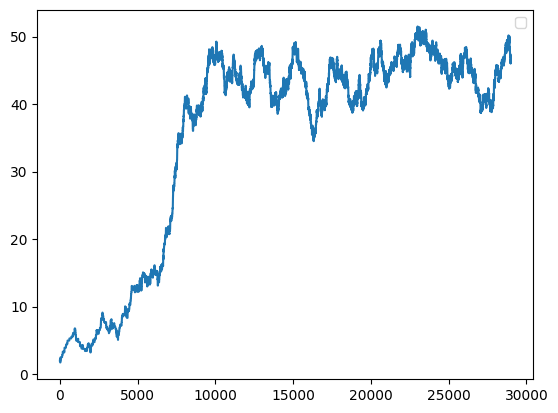

In [5]:
### YOUR CODE HERE
# Some plot stuff
Gk_avg = np.cumsum(G_list)
Gk_avg = Gk_avg[1000:] - Gk_avg[:-1000]
plt.plot(Gk_avg)
#plt.plot(lrs)
#plt.plot(eps)
plt.legend()
### END OF YOUR CODE

### 1b. Plot $||Q_k - Q^*||$

Note that use `Q_opt` for $Q^*$. It is given to you in the previous section of this file. You do not need to copy it from HW1.

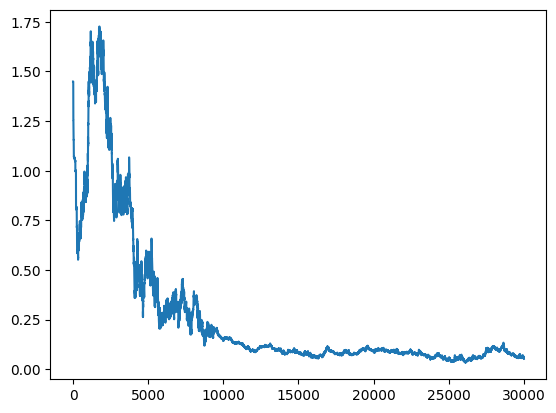

In [6]:
### YOUR CODE HERE
# Some plot stuff
plt.plot(convergence_list)
### END OF YOUR CODE

### 1c. Question

What is the policy and Q-value function obtained at the end of the learning? Are you
able to learn the optimal policy? That is, how to get the optimal policy from the optimal Q-value function?

In [7]:
### YOUR CODE HERE
print(Q)
print(Q_opt)
# Compute the final policy
P_star = np.argmax(Q, axis=1) 
P_opt  = np.argmax(Q_opt, axis=1) 
print(P_star)
print(P_opt)
### END OF YOUR CODE

[[0.0706 0.0661 0.0666 0.0581]
 [0.0356 0.0447 0.0388 0.065 ]
 [0.0827 0.0712 0.0708 0.0584]
 [0.0323 0.0405 0.0311 0.0573]
 [0.0988 0.0702 0.0615 0.0423]
 [0.     0.     0.     0.    ]
 [0.1183 0.0828 0.1014 0.0188]
 [0.     0.     0.     0.    ]
 [0.0659 0.1052 0.1004 0.1521]
 [0.1525 0.2564 0.2077 0.1238]
 [0.306  0.251  0.2382 0.1121]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.1784 0.2827 0.3907 0.2646]
 [0.3794 0.6506 0.6    0.5347]
 [0.     0.     0.     0.    ]]
[[0.0689 0.0666 0.0666 0.0597]
 [0.0391 0.043  0.0407 0.0614]
 [0.0744 0.0688 0.0727 0.0575]
 [0.0391 0.0391 0.0335 0.0558]
 [0.0918 0.0712 0.0643 0.0482]
 [0.     0.     0.     0.    ]
 [0.1122 0.0899 0.1122 0.0223]
 [0.     0.     0.     0.    ]
 [0.0712 0.1179 0.1018 0.1454]
 [0.1576 0.2475 0.2039 0.1335]
 [0.2996 0.266  0.2254 0.1079]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.1882 0.3057 0.3799 0.266 ]
 [0.3956 0.639  0.6149 0.5372]
 [0.     0.     0.     0.    ]]
[0 3 0

**Write your answer below.**  
Answer:

The Q-Value function itself seems to be getting reasonably close to the optimal Q-value. However it is not exactly the same. It is close enough that in most cases we get the optimal policy from $Q^*$.

I noticed that in some runs there are 1-2 states that result in a different action policy. These mostly seem to be concentrated on states where the $\epsilon-greedy$ doesn't visit as often.

## 2. Behavior Policy  

Implement tabular Q-learning with a uniformly random policy (where
each action is taken with equal probability) as the behavior policy. Compare the convergence
with the ε-greedy exploration approach. Explain your observations and inference. Can you
implement a better behavior policy and show its effectiveness?

[[0.0809 0.0792 0.0787 0.0702]
 [0.0432 0.0473 0.0432 0.0714]
 [0.0818 0.0751 0.0844 0.0667]
 [0.0449 0.0424 0.0402 0.0652]
 [0.1065 0.0822 0.0764 0.0555]
 [0.     0.     0.     0.    ]
 [0.1185 0.0932 0.1259 0.0253]
 [0.     0.     0.     0.    ]
 [0.0864 0.1303 0.1214 0.1617]
 [0.1728 0.2791 0.2204 0.157 ]
 [0.3149 0.2914 0.2565 0.1225]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.2188 0.3592 0.4133 0.3015]
 [0.4337 0.6778 0.6539 0.5477]
 [0.     0.     0.     0.    ]]
Pol_uni: [0 3 2 3 0 0 2 0 3 1 0 0 0 2 1 0]
Pol_opt: [0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]


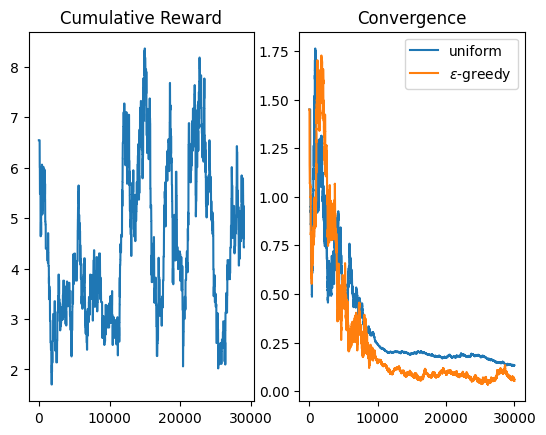

In [8]:
### YOUR CODE HERE
# Freestyle!
Q_uni = np.zeros((no_of_states, no_of_actions))
G_uni_list = [] # cumulative discounted reward in episode k
convergence_uni_list = [] # record ||Q_k-Q_STAR||_{2}

for k in range(max_episode):
    s0, _ = env.reset()  # start new episode
    path_k = [s0]  # initial state for new episode
    G_k = 0  # reset cumulative discounted reward for episode k
    for t in range(max_step):
        s_t = path_k[-1] # observe current state s_t
        a_t = np.random.randint(4)#env.action_space.sample()  # decide what action to take at step t
        ns_t, r_t, terminal, _, _ = env.step(a_t)  # take a step
        ### YOUR CODE HERE
        # TASK 3
        # Hint: you should call lr_decay somewhere here.
        lr = lr_decay(k)
        Q_uni[s_t][a_t] = Q_uni[s_t][a_t] + lr * (r_t + gamma * np.max(Q_uni[ns_t]) - Q_uni[s_t][a_t])
        ### END OF YOUR CODE
        G_k += (gamma ** t) * r_t  # update cumulative discounted reward
        path_k.append(ns_t)  # record next state
        if terminal:  # next state is a terminal state, episode ended
            break
    convergence_uni_list.append(np.linalg.norm(Q_uni.flatten()-Q_opt.flatten())) # calc and store Euclidean norm of Q_k-Q*
    G_uni_list.append(G_k) # record cumulative discounted reward for episode k

Gk_uni_avg = np.cumsum(G_uni_list)
Gk_uni_avg = Gk_uni_avg[1000:] - Gk_uni_avg[:-1000]

fig, axs = plt.subplots(1,2)
axs[0].plot(Gk_uni_avg)
axs[0].set_title("Cumulative Reward")
axs[1].plot(convergence_uni_list, label="uniform")
axs[1].plot(convergence_list, label="$\epsilon$-greedy")
axs[1].set_title("Convergence")
#plt.plot(lrs)
#plt.plot(eps)
plt.legend()

print(Q_uni)
# Compute the final policy
P_uni = np.argmax(Q_uni, axis=1) 
print("Pol_uni:", P_uni)
print("Pol_opt:", P_opt)

### END OF YOUR CODE

**Write your answer below.**  
Answer:

## 3. TD-Learning

Consider the following polices: (i) the optimal policy obtained from QVI,
and (ii) a uniformly random policy where each action is taken with equal probability. Learn
the value of the these polices using:

### 3a. Monte Carlo (MC) Learning

MC Uniform Estimate:
 [[0.0045 0.0044 0.0103 0.004 ]
 [0.0065 0.     0.0264 0.    ]
 [0.0189 0.0574 0.1132 0.    ]
 [0.     0.1251 0.4003 0.    ]]
Uniform Actual:
 [[0.0045 0.0042 0.0101 0.0041]
 [0.0067 0.     0.0263 0.    ]
 [0.0187 0.0576 0.107  0.    ]
 [0.     0.1304 0.3915 0.    ]]


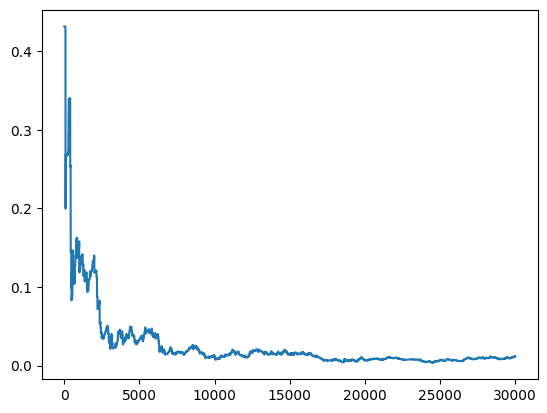

In [9]:
### YOUR CODE HERE
# Freestyle!

# MC For uniform policy
V_uni_act = np.array([0.0045,0.0042,0.0101,0.0041,0.0067,0.,0.0263,0.,0.0187,0.0576,
0.107,0.,0.,0.1304,0.3915,0.])

V_uni = np.zeros(no_of_states)
rs =  np.zeros(no_of_states)
vs = np.zeros(no_of_states) 
V_uni_conv_mc = []

for k in range(max_episode):
    #generate episode
    s_t, _ = env.reset()
    states, rewards = [] , []
    for t in range(max_step):
        states.append(s_t)
        s_t, r_t, term, _, _ = env.step(env.action_space.sample())
        rewards.append(r_t)

        if term:
            break

    G_k = 0  # reset cumulative discounted reward for episode k

    for idx, (s_t, r_t) in enumerate(zip(states[::-1],rewards[::-1])):
        G_k = gamma * G_k + r_t 
        if s_t not in states[:-(idx+1)]:
            rs[s_t] += G_k
            vs[s_t] += 1
            V_uni[s_t] = rs[s_t] / vs[s_t]

    V_uni_conv_mc.append(np.linalg.norm(V_uni - V_uni_act))


plt.plot(V_uni_conv_mc)
print("MC Uniform Estimate:\n",V_uni.reshape(4,-1))
print("Uniform Actual:\n", V_uni_act.reshape(4,-1))
### END OF YOUR CODE

MC Opt Estimate:
 [0.0669 0.0542 0.0682 0.     0.0891 0.     0.1108 0.     0.1421 0.2438
 0.2968 0.     0.     0.3737 0.6358 0.    ]
MC Opt Actual:
 [0.0689 0.0614 0.0744 0.0558 0.0918 0.     0.1122 0.     0.1454 0.2475
 0.2996 0.     0.     0.3799 0.639  0.    ]


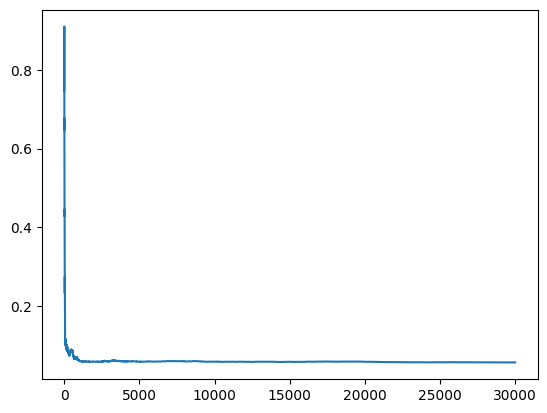

In [38]:
# MC for Optimal Policy

V_opt_act = np.max(Q_opt, axis=1)
V_opt = np.zeros(no_of_states)
rs =  np.zeros(no_of_states)
vs = np.zeros(no_of_states) 
V_opt_conv_mc = []

for k in range(max_episode):
    #generate episode
    s_t, _ = env.reset()
    states, rewards = [] , []
    for t in range(max_step):
        states.append(s_t)
        s_t, r_t, term, _, _ = env.step(P_opt[s_t])
        rewards.append(r_t)

        if term:
            break

    G_k = 0  # reset cumulative discounted reward for episode k

    for idx, (s_t, r_t) in enumerate(zip(states[::-1],rewards[::-1])):
        G_k = gamma * G_k + r_t 
        #if s_t not in states[:-(idx+1)]:
        rs[s_t] += G_k
        vs[s_t] += 1
        V_opt[s_t] = rs[s_t] / vs[s_t]

    V_opt_conv_mc.append(np.linalg.norm(V_opt - V_opt_act))

plt.plot(V_opt_conv_mc)
print("MC Opt Estimate:\n",V_opt)
print("MC Opt Actual:\n",V_opt_act)


### 3b. Temporal Difference (TD) Learning

TD Value Estimate: [0.0039 0.0042 0.0097 0.0038 0.0053 0.     0.0242 0.     0.0164 0.0471
 0.0944 0.     0.     0.1148 0.371  0.    ]
Value Actual: [0.0045 0.0042 0.0101 0.0041 0.0067 0.     0.0263 0.     0.0187 0.0576
 0.107  0.     0.     0.1304 0.3915 0.    ]


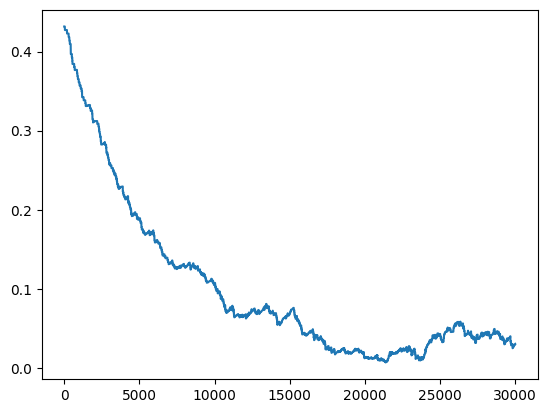

In [34]:
### YOUR CODE HERE
# Freestyle!
V_uni = np.zeros(no_of_states)
convergence_uni_list_td = []
alpha = 0.005

for k in range(max_episode):

    s_t, _ = env.reset()

    for t in range(max_step):
        ns_t, r_t, terminal, _, _ = env.step(env.action_space.sample())  # take a step
        V_uni[s_t] = V_uni[s_t] + alpha * (r_t + gamma * V_uni[ns_t] - V_uni[s_t]) 
        s_t = ns_t

        if terminal:
            break

    convergence_uni_list_td.append(np.linalg.norm(V_uni - V_uni_act))


print("TD Value Estimate:", V_uni)
print("Value Actual:", V_uni_act)
plt.plot(convergence_uni_list_td)
### END OF YOUR CODE

TD Value Estimate: [0.0678 0.0626 0.0735 0.     0.0891 0.     0.1073 0.     0.1399 0.239
 0.2788 0.     0.     0.3708 0.6203 0.    ]
Value Actual: [0.0689 0.0614 0.0744 0.0558 0.0918 0.     0.1122 0.     0.1454 0.2475
 0.2996 0.     0.     0.3799 0.639  0.    ]


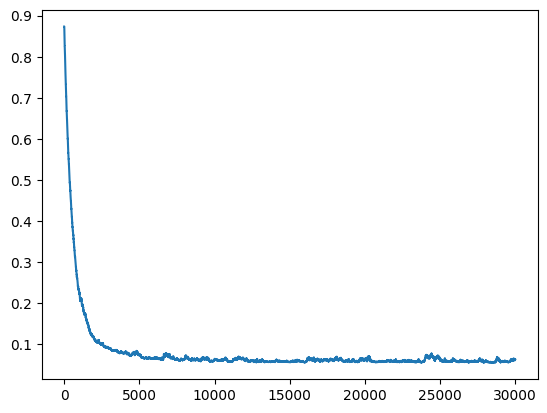

In [31]:
V_opt = np.zeros(no_of_states)
convergence_opt_list_td = []
alpha = 0.003

for k in range(max_episode):

    s_t, _ = env.reset()

    for t in range(max_step):
        ns_t, r_t, terminal, _, _ = env.step(P_opt[s_t])  # take a step
        V_opt[s_t] = V_opt[s_t] + alpha * (r_t + gamma * V_opt[ns_t] - V_opt[s_t]) 
        s_t = ns_t

        if terminal:
            break

    convergence_opt_list_td.append(np.linalg.norm(V_opt - V_opt_act))


print("TD Value Estimate:", V_opt)
print("Value Actual:", V_opt_act)
plt.plot(convergence_opt_list_td)


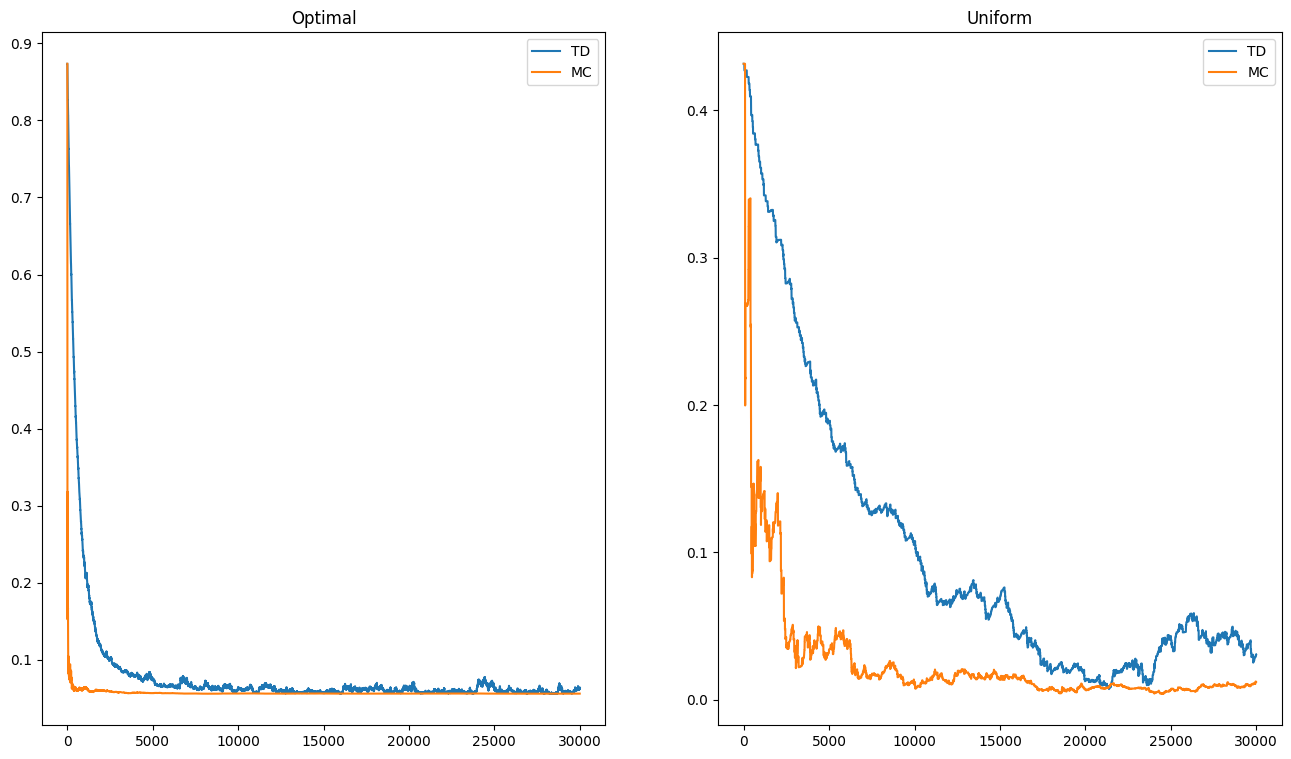

In [37]:
# compare MC vs TD

fig, axs = plt.subplots(1,2,figsize=(16,9))
axs[0].plot(convergence_opt_list_td,label="TD")
axs[0].plot(V_opt_conv_mc, label="MC")
axs[0].set_title("Optimal")
axs[0].legend()

axs[1].plot(convergence_uni_list_td,label="TD")
axs[1].plot(V_uni_conv_mc, label="MC")
axs[1].set_title("Uniform")
axs[1].legend()


### 3c. What are the trade-offs of between MC vs TD?

**Write your answer below.**  
Answer: